# MNIST - fashion prediction

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

import matplotlib.pyplot as plt

load data  
this dataset download at $HOME/.keras/datasets

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# copy data
train_X = train_images.copy()
train_y = train_labels.copy()
test_X = test_images.copy()
test_y = test_labels.copy()

## <u>EDA</u>

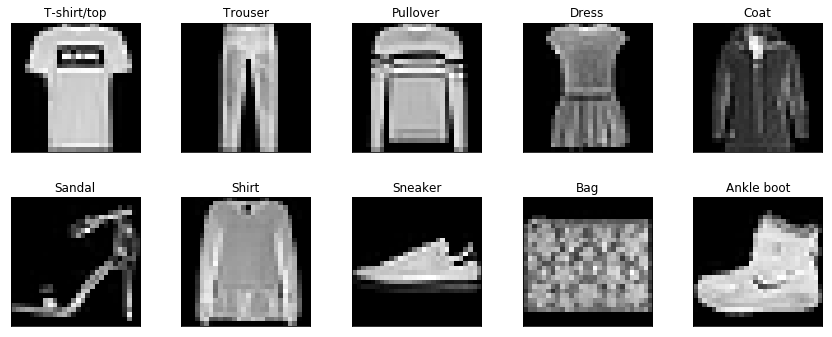

In [4]:
# 10개 카테고리 이미지 확인하기
def display_sample_img(X, y):
    category = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
                 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
    fig, axes = plt.subplots(nrows=2, ncols=5)
    fig.set_size_inches(12,5)
    fig.tight_layout()
    num = 0
    for idx in range(2):
        for jdx in range(5):
            for index, label in enumerate(y):
                if label == num:
                    axes[idx][jdx].imshow(X[index], cmap='gray')
                    axes[idx][jdx].set_title(category[num])
                    axes[idx][jdx].set_xticks([])
                    axes[idx][jdx].set_yticks([])
                    num += 1
                    break

display_sample_img(train_X, train_y)

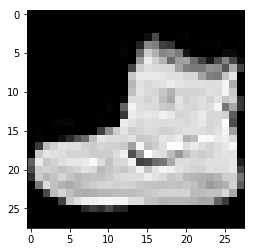

In [5]:
plt.imshow(train_X[0], cmap='gray')

## <u>preprocessing</u>

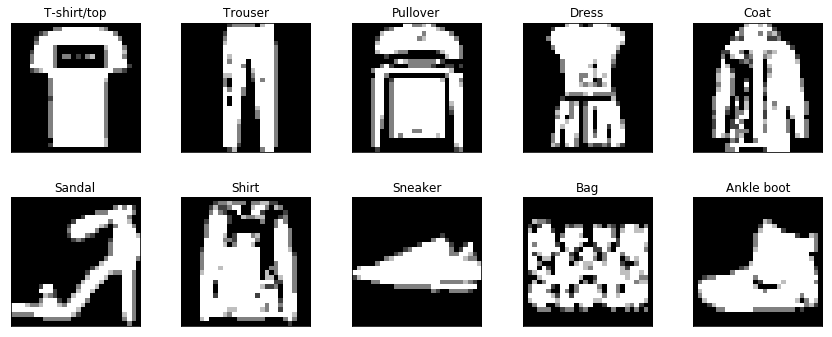

In [6]:
# 이미지 전처리 함수
def img_pipeline(img):
    import cv2
    img = cv2.resize(img, dsize=(0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR) # 확대
    img = cv2.equalizeHist(img) # 평활화
    ret,img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # 이진화
    img = cv2.resize(img, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR) # 축소
    return img

# 적용
train = []
test = []
for img in train_X:
    train.append(img_pipeline(img))
for img in test_X:
    test.append(img_pipeline(img))    
train_X, test_X = train.copy(), test.copy()

# 확인
display_sample_img(train_X, train_y)

In [7]:
np.array(train_X).shape

(60000, 28, 28)

In [0]:
def ohe(ndarr):
    res = []
    for idx in ndarr:
        ohe_arr = [0]*10
        ohe_arr[idx[0]] = 1
        res.append(ohe_arr)
    return np.array(res)

# one-hot-encoding
train_y = ohe(train_y.reshape(-1,1))
test_y = ohe(test_y.reshape(-1,1))

# reshape (?,56*56)
train_X = np.array(train_X)
test_X = np.array(test_X)
train_X = train_X.reshape(len(train_X),-1)
test_X = test_X.reshape(len(test_X),-1)

# normalization
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# train_X = ss.fit_transform(train_X)
# test_X = ss.fit_transform(test_X)
train_X = train_X/255
test_X = test_X/255

In [9]:
test_y.shape

(10000, 10)

## <u>modelling</u>

In [0]:
fashion_classes = 10
learning_rate = 0.0005
width = 100
training_epochs = 200
batch_size = 600

In [0]:
minimum_cost = {'cost':1.0, 'accuracy':0.0, 'learning_rate':learning_rate, 'training_epochs':training_epochs, 'width':width, 'batch_size':batch_size}

In [0]:
# tf.reset_default_graph() #그래프에 있는 모든 텐서를 초기화
# x=tf.placeholder(tf.float32, [None,28*28])
# y=tf.placeholder(tf.float32, [None,10])

# keep_prob=tf.placeholder(tf.float32)

# w1=tf.get_variable("w1", shape=[28*28,width],initializer=tf.contrib.layers.xavier_initializer())
# b1=tf.Variable(tf.random_normal([width]))
# L1=tf.nn.relu(tf.matmul(x,w1)+b1)
# L1=tf.nn.dropout(L1, keep_prob=keep_prob)

# w2=tf.get_variable("w2", shape=[width,width],initializer=tf.contrib.layers.xavier_initializer())
# b2=tf.Variable(tf.random_normal([width]))
# L2=tf.nn.relu(tf.matmul(L1,w2)+b2)
# L2=tf.nn.dropout(L2, keep_prob=keep_prob)


# w3=tf.get_variable("w3", shape=[width,width],initializer=tf.contrib.layers.xavier_initializer())
# b3=tf.Variable(tf.random_normal([width]))
# L3=tf.nn.relu(tf.matmul(L2,w3)+b3)
# L3=tf.nn.dropout(L3, keep_prob=keep_prob)


# w4=tf.get_variable("w4", shape=[width,width],initializer=tf.contrib.layers.xavier_initializer())
# b4=tf.Variable(tf.random_normal([width]))
# L4=tf.nn.relu(tf.matmul(L3,w4)+b4)
# L4=tf.nn.dropout(L4, keep_prob=keep_prob)


# w5=tf.get_variable("w5", shape=[width,10],initializer=tf.contrib.layers.xavier_initializer())
# b5=tf.Variable(tf.random_normal([10]))
# hf=tf.matmul(L4,w5)+b5

# cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
#                (logits=hf, labels=y))
# train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# is_correct=tf.equal(tf.argmax(hf,1), tf.argmax(y,1))
# accuracy=tf.reduce_mean(tf.cast(is_correct, tf.float32))


tf.reset_default_graph() #그래프에 있는 모든 텐서를 초기화

keep_prob=tf.placeholder(tf.float32)

x=tf.placeholder(tf.float32, [None, 28*28])
ximg=tf.reshape(x, [-1, 28, 28, 1])#img 28*28*1(black/white)
y=tf.placeholder(tf.float32, [None, 10])

w1=tf.Variable(tf.random_normal([3,3,1,32]))
L1=tf.nn.conv2d(ximg, w1, strides=[1,1,1,1],padding='SAME')
L1=tf.nn.relu(L1)
L1=tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L1=tf.nn.dropout(L1, keep_prob=keep_prob)
#L1 이미지 shape => (?, 28, 28, 1)
#conv => (?,28,28,32)
#pooling -> (?,14,14,32)

w2=tf.Variable(tf.random_normal([3,3,32,64]))
L2=tf.nn.conv2d(L1, w2, strides=[1,1,1,1],padding='SAME')
L2=tf.nn.relu(L2)
L2=tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L2=tf.nn.dropout(L2, keep_prob=keep_prob)
#conv2d (?,14,14,64)
#relu (?,14,14,64)
#max_pool (?,7,7,64)
L2_flat=tf.reshape(L2, [-1, 7*7*64])
#reshape => (?, 7*7*64)


w3=tf.get_variable("w3", shape=[7*7*64, 10],initializer=tf.contrib.layers.xavier_initializer())
b=tf.Variable(tf.random_normal([10]))
logits=tf.matmul(L2_flat, w3)+b
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

is_correct=tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(is_correct, tf.float32))



Epoch:     1 cost:  4.664133213
Epoch:     2 cost:  1.645321995
Epoch:     3 cost:  1.291101145
Epoch:     4 cost:  1.089089024
Epoch:     5 cost:  0.976082894
Epoch:     6 cost:  0.851046243
Epoch:     7 cost:  0.793494525
Epoch:     8 cost:  0.739887729
Epoch:     9 cost:  0.656905746
Epoch:    10 cost:  0.605691685
Epoch:    11 cost:  0.596467958
Epoch:    12 cost:  0.578076037
Epoch:    13 cost:  0.514552805
Epoch:    14 cost:  0.488021231
Epoch:    15 cost:  0.468882798
Epoch:    16 cost:  0.439953842
Epoch:    17 cost:  0.426546032
Epoch:    18 cost:  0.425357359
Epoch:    19 cost:  0.396024671
Epoch:    20 cost:  0.368103171
Epoch:    21 cost:  0.369286629
Epoch:    22 cost:  0.343005203
Epoch:    23 cost:  0.328389439
Epoch:    24 cost:  0.310652127
Epoch:    25 cost:  0.326570792
Epoch:    26 cost:  0.315503563
Epoch:    27 cost:  0.291339516
Epoch:    28 cost:  0.287851771
Epoch:    29 cost:  0.283360846
Epoch:    30 cost:  0.298853697
Epoch:    31 cost:  0.264625223
Epoch:  

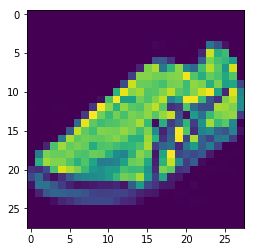

In [29]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        # 1에폭당 셔플 해야함!!
        shuffled_index = np.arange(train_X.shape[0])
        np.random.shuffle(shuffled_index)
        train_X = train_X[shuffled_index]
        train_y = train_y[shuffled_index]
        
        avg_cost = 0
        idx = 0
        total_batch = int(train_X.shape[0] / batch_size)
        for _ in range(total_batch):
            batch_xs = train_X[idx:idx+batch_size]
            batch_ys = train_y[idx:idx+batch_size]
            myfeed={x:batch_xs, y:batch_ys, keep_prob:1}
            cv, _ = sess.run([cost, train], feed_dict=myfeed)
            avg_cost += cv/total_batch
            idx += batch_size
            
        print('Epoch: ', '%4d'%(epoch+1),
              'cost: ', '{:.9f}'.format(avg_cost))
    
    print('learning finished')
    acc = sess.run(accuracy, feed_dict={x:test_X, y:test_y, keep_prob:1})
    print('accuracy: ', acc)
    if minimum_cost['cost'] > avg_cost:
        minimum_cost['cost'] = avg_cost
        minimum_cost['accuracy'] = acc
        minimum_cost['learning_rate'] = learning_rate
        minimum_cost['training_epochs'] = training_epochs
        minimum_cost['batch_size'] = batch_size

    import random
    r = random.randint(0, len(test_images)-1)
    print('Label: ', sess.run(tf.argmax(test_y[r:r+1], 1)))
    print('Prediction: ', sess.run(tf.argmax(logits,1), feed_dict={x:test_X[r:r+1], keep_prob:1}))
    plt.imshow(test_images[r:r+1].reshape(28,28))
    plt.show()

In [30]:
minimum_cost

{'accuracy': 0.8608,
 'batch_size': 600,
 'cost': 0.016637253416702143,
 'learning_rate': 0.0005,
 'training_epochs': 200,
 'width': 100}